<a href="https://colab.research.google.com/github/danperazzo/computational_creativity/blob/master/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Visualization for Neural Networks

In the following tutorial we will use Feature Visualization techniques to create really cool abstract images. For this, we will use the [lucid visualition library](https://github.com/tensorflow/lucid) coupled with [Tensorflow at version 1.15](https://www.tensorflow.org/?hl=pt-br)

![](https://storage.googleapis.com/tensorflow-lucid/notebooks/xy2rgb/cppn-header.jpg)
This tutorial will teach you how to use Feature Visualizations for creating really cool abstract images. 

This tutorial is heavily based on the colab notebook provided in [this link](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/differentiable-parameterizations/xy2rgb.ipynb). Thanks for the authors for sharing the code with the Apache 2.0 License. If you want to know more about this topic, we recommend you to check out [this repo](https://github.com/tensorflow/lucid).




## Introduction: WTF are these things?

First off. What the hell are Feature Visualizations? 
To respond, let's imagine a classifier. We can imagine that the neurons fire up to detect the objects they are looking for. But, what are the neurons seeing? Why are they firing in such a way? 

<img src="https://drive.google.com/uc?export=view&id=18TC1mNkqZl8RqDwBG29m2V4vjMKRvbvz" width="900"></img>

Feature visualizations let us see what estimulates each neuron. In the above images we can see that some neurons were estimulated by snouts, other neurons where estimulated by fluffiness, etc. The idea is, instead of optimizing the neural network's weights during to accomodate the input, in here we optimized the image to maximize the neuron's activation. In this tutorial we will see some ideas and create some cool visualizations.


So in, the following section, we will see some neurons firing up and, finally, create some trippy images. 

## Install, Import, and load a model

In here we will just import and install the necessary modules, including Tensorflow and Lucid

In [ ]:
!pip uninstall numpy # Just in case someone already has the numpy installed
!pip install numpy==1.16.1
import numpy as np

Uninstalling numpy-1.16.1:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.6
    /usr/local/lib/python3.6/dist-packages/numpy-1.16.1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/numpy/*
Proceed (y/n)? y
  Successfully uninstalled numpy-1.16.1
  Using cached https://files.pythonhosted.org/packages/f5/bf/4981bcbee43934f0adb8f764a1e70ab0ee5a448f6505bd04a87a2fda2a8b/numpy-1.16.1-cp36-cp36m-manylinux1_x86_64.whl
ERROR: umap-learn 0.4.6 has requirement numpy>=1.17, but you'll have numpy 1.16.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [ ]:
!pip install -q lucid>=0.2.3

In [ ]:
!pip uninstall tensorflow
!pip install tensorflow-gpu==1.15
%tensorflow_version 1.x # Just in case... Lucid only works for Tensorflow == 1.x

Uninstalling tensorflow-2.3.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.3.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/cli/base_command.py", line 153, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/uninstall.py", line 79, in run
    auto_confirm=options.yes, verbose=self.verbosity > 0,
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/req/req_install.py", line 755, in uninstall
    uninstalled_pathset.remove(auto_confirm, verbose)
  File "/usr/local/lib/python3.6/dist-packages

In [ ]:
# For video rendering

!pip install -q moviepy
!imageio_download_bin ffmpeg
!pip install --upgrade tf_slim

Ascertaining binaries for: ffmpeg.
Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1490944/45929032 bytes (3.2%)4423680/45929032 bytes (9.6%)8273920/45929032 bytes (18.0%)12460032/45929032 bytes (27.1%)15835136/45929032 bytes (34.5%)20111360/45929032 bytes (43.8%)23797760/45929032 bytes (51.8%)27131904/45929032 bytes (59.1%)31277056/45929032 bytes (68.1%)35528704/45929032 bytes (77.4%)39731200/45929032 bytes (86.5%)43409408/45929032 bytes (94.

Now we will just import the necessary packages for our tutorial

In [ ]:
from __future__ import print_function
import io
import string
import numpy as np
import PIL
import base64
from glob import glob

import matplotlib.pylab as pl

import tensorflow as tf
import tf_slim as slim

from IPython.display import clear_output, Image, display, HTML

import moviepy.editor as mpy
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


from google.colab import files

In [ ]:
from lucid.modelzoo import vision_models
from lucid.misc.io import show, save, load
from lucid.optvis import objectives
from lucid.optvis import param
from lucid.optvis import render
from lucid.misc.tfutil import create_session

## Getting Started: Neural visualizations

In this module, we will just be playing around and creating some images. To do this, we will optimize an image to fire up some neuron as much as possible. First, we will need to load a model just to see what we are talking about.

In [ ]:
model = vision_models.InceptionV1()
model.load_graphdef()

Now, with the model loaded, let's visualize what is happenning on a certain neuron. 

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


512 1512.1735



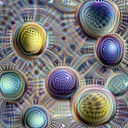

In [ ]:
obj = objectives.channel("mixed4a_pre_relu", 465)
_ = render.render_vis(model, obj)

We can try different layers channels, in particular, we can see that if we put shallower layers, the images get simpler, as expected given how ConNets work.

512 181.5227



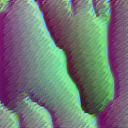

In [ ]:
obj = objectives.channel("conv2d2", 10)
_ = render.render_vis(model, obj)

## Some cool things you can do

On the introductory side, we can do some cool things with feature visualizations:

512 2239.6653



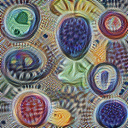

In [ ]:
# We could optimize two neurons at the same time

channel = lambda n: objectives.channel("mixed4a_pre_relu", n)
obj = channel(476) + channel(465)
_ = render.render_vis(model, obj)

512 3210.1562



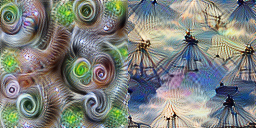

In [ ]:
# We could see two images: on the left we see the image that estimulates less the neuron. 
# On the right the image that estimulates the neuron more.

param_f = lambda: param.image(128, batch=2)
obj = objectives.channel("mixed4a_pre_relu", 492, batch=1) - objectives.channel("mixed4a_pre_relu", 492, batch=0)
_ = render.render_vis(model, obj, param_f)

512 448.80084



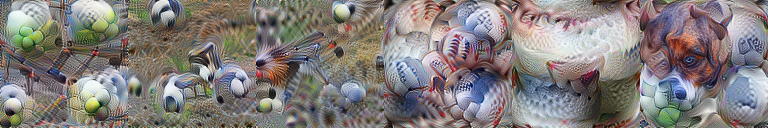

In [ ]:
#Finally, using techniques better explained on here: https://distill.pub/2017/feature-visualization/
# We can better see this neuron firing on a diversity of settings

param_f = lambda: param.image(128, batch=6)
obj = objectives.channel("mixed5a_pre_relu", 9) - 1e2*objectives.diversity("mixed5a")
_ = render.render_vis(model, obj, param_f)

## Getting started with Differentiable Image Parametrization: CPPNs

Well we are over with the preliminaries, and let's see what we can do. Differentiable Image Parametrization is just a really cool way to parametize an image so that it is differentiable. In particular,in this section we will see how we can use Compositional Pattern Producing Networks(CPPNs) to create trippy images. 

CPPNs are just a network whose weights parametrize an image. Our idea is to optimize the weights so that our specified CNN channels gets as activated as possible. In doing this, we will create some trully great images. 

<img src="https://drive.google.com/uc?export=view&id=1ZtCzBCbHmzt8Kkp0xvke-AMnGJTqMBYn" width="900"></img>

In [ ]:
def composite_activation(x):
  x = tf.atan(x)
  # Coefficients computed by:
  #   def rms(x):
  #     return np.sqrt((x*x).mean())
  #   a = np.arctan(np.random.normal(0.0, 1.0, 10**6))
  #   print(rms(a), rms(a*a))
  return tf.concat([x/0.67, (x*x)/0.6], -1)


def composite_activation_unbiased(x):
  
  x = tf.atan(x)
  # Coefficients computed by:
  #   a = np.arctan(np.random.normal(0.0, 1.0, 10**6))
  #   aa = a*a
  #   print(a.std(), aa.mean(), aa.std())
  return tf.concat([x/0.67, (x*x-0.45)/0.396], -1)


def relu_normalized(x):
  x = tf.nn.relu(x)
  # Coefficients computed by:
  #   a = np.random.normal(0.0, 1.0, 10**6)
  #   a = np.maximum(a, 0.0)
  #   print(a.mean(), a.std())
  return (x-0.40)/0.58


def image_cppn(
    size,
    num_output_channels=3,
    num_hidden_channels=24,
    num_layers=8,
    activation_fn=composite_activation,
    normalize=False):
  r = 3.0**0.5  # std(coord_range) == 1.0
  coord_range = tf.linspace(-r, r, size)
  y, x = tf.meshgrid(coord_range, coord_range, indexing='ij')
  net = tf.expand_dims(tf.stack([x, y], -1), 0)  # add batch dimension
  with slim.arg_scope([slim.conv2d], kernel_size=1, activation_fn=None):
    for i in range(num_layers):
      in_n = int(net.shape[-1])
      net = slim.conv2d(
          net, num_hidden_channels,
          # this is untruncated version of tf.variance_scaling_initializer
          weights_initializer=tf.random_normal_initializer(0.0, np.sqrt(1.0/in_n)),
      )
      if normalize:
        net = slim.instance_norm(net)
      net = activation_fn(net)

    rgb = slim.conv2d(net, num_output_channels, activation_fn=tf.nn.sigmoid,
                      weights_initializer=tf.zeros_initializer())
  return rgb

In [ ]:
################YOUR CODE HERE#################################
#Test which models will go here, we recommend using the models: InceptionV1,
model = vision_models.InceptionV1()
#model = vision_models.VGG19_caffe()
#model = vision_models.AlexNet()
################YOUR CODE HERE#################################
model.load_graphdef()

Just to give you a sense of how BIG this module is, it has exactly:

In [ ]:
with tf.Graph().as_default():
  image_cppn(224)
  variables = tf.get_collection('variables')
  param_n = sum([v.shape.num_elements() for v in variables])
  print('This amount of parameters:', param_n)

Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Please use `layer.__call__` method instead.


This amount of parameters: 8451


Now, let's go on and perform feature visualizations. The fun starts now! We will test our feature visualization framework with more examples. Here you will alter the neurons and different models, bellow is a list of images for you to test. Just substitute the string_obj for the required string.

If you are testing on InceptionV1Net, try -> ''conv2d2','mixed4a_3x3_pre_relu' and 'head0_bottleneck'

If you are testing on VGG19-, try -> 'conv3_3/conv3_3', 'conv5_3/conv5_3' and
'fc7/fc7'

If you are testing on AlexNet-, try -> 'Conv2D_2', 'Conv2D_5' and
'Conv2D_7'

To see the full list of other node names for these three models, or any other model you might want to check [this link](https://github.com/tensorflow/lucid/tree/master/lucid/modelzoo). 
As expected the deeper we get our neurons the more complex and interesting the images get.



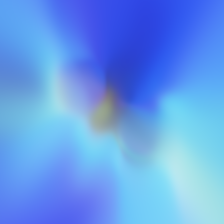
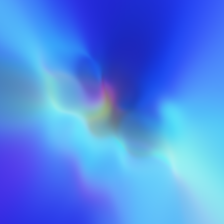
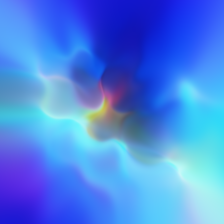
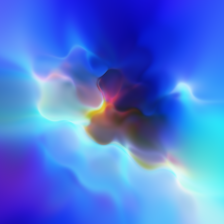
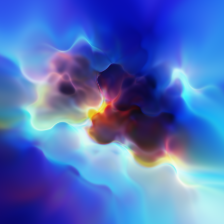

In [ ]:
string_obj= 'head0_bottleneck'


def render_feature(
    cppn_f = lambda: image_cppn(224),
    optimizer = tf.train.AdamOptimizer(0.005),
    objective = objectives.channel(string_obj, 20)):
  vis = render.render_vis(model, objective, param_f=cppn_f, optimizer=optimizer, transforms=[], thresholds=[2**i for i in range(5,10)], verbose=False)
  show(vis)

render_feature()

You can also alter the activation function (and try to create one yourself!) in here. We have the composite_activation, composite_activation_unbiased and relu_normalized functions.


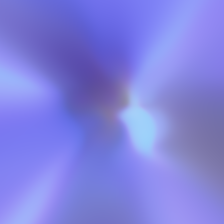
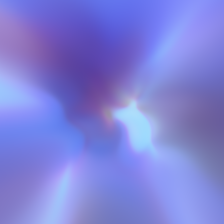
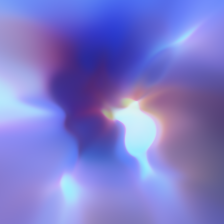
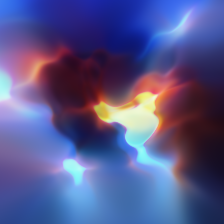
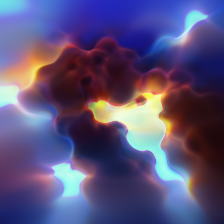

In [ ]:
render_feature(
    cppn_f=lambda: image_cppn(224, activation_fn=composite_activation))

##Goodbye


Sadly this really small tutorial just ended. However, you can check out these awesome links:

###Repositories
* [Lucid](https://github.com/tensorflow/lucid/)

###Recomended Reading

* [Feature Visualization](https://distill.pub/2017/feature-visualization/)
* [The Building Blocks of Interpretability](https://distill.pub/2018/building-blocks/)
* [Using Artiﬁcial Intelligence to Augment Human Intelligence](https://distill.pub/2017/aia/)
* [Visualizing Representations: Deep Learning and Human Beings](http://colah.github.io/posts/2015-01-Visualizing-Representations/)
* [Differentiable Image Parameterizations](https://distill.pub/2018/differentiable-parameterizations/)
* [Activation Atlas](https://distill.pub/2019/activation-atlas/)

### Related Talks
* [Lessons from a year of Distill ML Research](https://www.youtube.com/watch?v=jlZsgUZaIyY) (Shan Carter, OpenVisConf)
* [Machine Learning for Visualization](https://www.youtube.com/watch?v=6n-kCYn0zxU) (Ian Johnson, OpenVisConf)